Special thanks to Abraham Ybarra for the feature selection code.

# Libraries and importing data

In [1]:
import numpy as np
import scipy as sp
import sklearn as sk
import pandas as pd
import re
import pickle

### Visualization packages

In [2]:
import matplotlib.pyplot as plt
import seaborn as sb

### Scikit learn for Decision Tree

In [3]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, SelectPercentile, chi2, RFE, RFECV
from sklearn.feature_selection import RFE

Import below contained functions used in the class frequenctly.

In [4]:
import info5604_utils as util

### Importing the data. Dataset is multileveled so it needs to be imported this way

Display more columns

In [5]:
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', None)

In [6]:
df = pd.read_csv('../clean_data/data.csv', header=[0,1,2],index_col=[0])
print(df.shape)
df.head()

(7566, 104)


Info                       \
                                             MatchID                        
                                             Address League  Year  Season   
0  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
1  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
2  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
3  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   
4  http://matchhistory.na.leagueoflegends.com/en/...  NALCS  2015  Spring   

                                        Blue                        \
                            BlueTag      Top                Jungle   
     Type gamelength Winner TeamTag      Top  TopChamp      Jungle   
0  Season         40   Blue     TSM    Dyrus    Irelia    Santorin   
1  Season         38    Red     CST     Cris      Gnar     Impaler   
2  Season         40   Blue     WFX  Flaresz  Renekton  ShorterACE   
3  Season         41    Red     TIP     Rhux    Irelia        Rush   
4  Season         35   Blue     CLG    Benny      Gnar     Xmithie   

                                                                        \
                    Middle                     ADC             Support   
  JungleChamp       Middle MiddleChamp         ADC  ADCChamp   Support   
0      RekSai     Bjergsen        Ahri  WildTurtle      Jinx   Lustboy   
1      Rengar        Jesiz        Ahri        Mash   Caitlyn     Sheep   
2      Rengar     Pobelter        Fizz       Altec     Sivir     Gleeb   
3    JarvanIV  XiaoWeiXiao     Leblanc      Apollo     Sivir    Adrian   
4    JarvanIV         Link   Lissandra  Doublelift  Tristana  aphromoo   

                  Info          Red                                     \
                RedTag          Top                 Jungle               
  SupportChamp TeamTag          Top TopChamp        Jungle JungleChamp   
0        Janna      C9        Balls     Gnar        Meteos       Elise   
1        Leona     DIG        Gamsu   Irelia       Crumbzz    JarvanIV   
2        Annie      GV     Hauntzer     Sion  Saintvicious      LeeSin   
3       Thresh      TL         Quas     Gnar    IWDominate        Nunu   
4        Janna      T8  CaliTrlolz8     Sion     Porpoise8      RekSai   

                                                                          \
     Middle                       ADC               Support                
     Middle MiddleChamp           ADC ADCChamp      Support SupportChamp   
0       Hai        Fizz        Sneaky    Sivir  LemonNation       Thresh   
1  Shiphtur        Azir        CoreJJ    Corki      KiWiKiD        Annie   
2     Keane        Azir           Cop    Corki   BunnyFuFuu        Janna   
3     Fenix        Lulu         KEITH   KogMaw      Xpecial        Janna   
4  Slooshi8        Lulu  Maplestreet8    Corki        Dodo8        Annie   

    Info                     Blue                      Red                  \
    diff                 TeamGold                 TeamGold                   
  Gold_5 Gold_10 Gold_15   Gold_5 Gold_10 Gold_15   Gold_5 Gold_10 Gold_15   
0   -268    -625    -790     5068   11361   18324     5336   11986   19114   
1    147    -242    1394     5511   11419   19698     5364   11661   18304   
2     34     913    2922     4933   12374   21237     4899   11461   18315   
3    228      16    -335     5398   12033   19332     5170   12017   19667   
4    113     205    -574     5404   11943   19426     5291   11738   20000   

    Blue                                                                       \
     Top                 Jungle                 Middle                    ADC   
  Gold_5 Gold_10 Gold_15 Gold_5 Gold_10 Gold_15 Gold_5 Gold_10 Gold_15 Gold_5   
0    893    2051    3630   1049    2486    3632   1102    2663    4608   1127   
1   1127    2406    4594   1176    2350    3929   1102    2547    4549   1182   
2    828    2419    4187   1041    2552    40

In [7]:
y = df['Info','MatchID','Winner']
X = df.drop(['Winner','Address'],level = 2,axis=1)
X = X.drop([('Blue', 'Structures', 'Inhib'),( 'Red', 'Structures', 'Inhib')],axis=1)

Creating the Training, Validation, and Testing sets

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 2023, stratify=y)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2023, stratify=y_train)

# Decision Tree

Creating the model and the pipeline to search for the optimal parameters

In [10]:
model = DecisionTreeClassifier(random_state=2023)

In [11]:
CATEGORICAL_VARS = [('Info','MatchID','League'),
                    ('Info','MatchID','Year'),
                    ('Info','MatchID','Season'),
                    ('Info','MatchID','Type'),
                    ('Info','BlueTag','TeamTag'),
                    ('Blue','Top','Top'),
                    ('Blue','Top','TopChamp'),
                    ('Blue','Jungle','Jungle'),
                    ('Blue','Jungle','JungleChamp'),
                    ('Blue','Middle','Middle'),
                    ('Blue','Middle','MiddleChamp'),
                    ('Blue','ADC','ADC'),
                    ('Blue','ADC','ADCChamp'),
                    ('Blue','Support','Support'),
                    ('Blue','Support','SupportChamp'),
                    ('Info','RedTag','TeamTag'),
                    ('Red','Top','Top'),
                    ('Red','Top','TopChamp'),
                    ('Red','Jungle','Jungle'),
                    ('Red','Jungle','JungleChamp'),
                    ('Red','Middle','Middle'),
                    ('Red','Middle','MiddleChamp'),
                    ('Red','ADC','ADC'),
                    ('Red','ADC','ADCChamp'),
                    ('Red','Support','Support'),
                    ('Red','Support','SupportChamp'),
                    ('Blue','Bans','ban_1'),
                    ('Blue','Bans','ban_2'),
                    ('Blue','Bans','ban_3'),
                    ('Blue','Bans','ban_4'),
                    ('Blue','Bans','ban_5'),
                    ('Red','Bans','ban_1'),
                    ('Red','Bans','ban_2'),
                    ('Red','Bans','ban_3'),
                    ('Red','Bans','ban_4'),
                    ('Red','Bans','ban_5')
                   ]

NUMERIC_VARS = [('Info','MatchID','gamelength'),
                ('Info','diff','Gold_5'),
                ('Info','diff','Gold_10'),
                ('Info','diff','Gold_15'),
                ('Blue','TeamGold','Gold_5'),
                ('Blue','TeamGold','Gold_10'),
                ('Blue','TeamGold','Gold_15'),
                ('Red','TeamGold','Gold_5'),
                ('Red','TeamGold','Gold_10'),
                ('Red','TeamGold','Gold_15'),
                ('Blue','Top','Gold_5'),
                ('Blue','Top','Gold_10'),
                ('Blue','Top','Gold_15'),
                ('Blue','Jungle','Gold_5'),
                ('Blue','Jungle','Gold_10'),
                ('Blue','Jungle','Gold_15'),
                ('Blue','Middle','Gold_5'),
                ('Blue','Middle','Gold_10'),
                ('Blue','Middle','Gold_15'),
                ('Blue','ADC','Gold_5'),
                ('Blue','ADC','Gold_10'),
                ('Blue','ADC','Gold_15'),
                ('Blue','Support','Gold_5'),
                ('Blue','Support','Gold_10'),
                ('Blue','Support','Gold_15'),
                ('Red','Top','Gold_5'),
                ('Red','Top','Gold_10'),
                ('Red','Top','Gold_15'),
                ('Red','Jungle','Gold_5'),
                ('Red','Jungle','Gold_10'),
                ('Red','Jungle','Gold_15'),
                ('Red','Middle','Gold_5'),
                ('Red','Middle','Gold_10'),
                ('Red','Middle','Gold_15'),
                ('Red','ADC','Gold_5'),
                ('Red','ADC','Gold_10'),
                ('Red','ADC','Gold_15'),
                ('Red','Support','Gold_5'),
                ('Red','Support','Gold_10'),
                ('Red','Support','Gold_15'),
                ('Blue','Structures','Towers'),
                ('Red','Structures','Towers'),
                ('Blue','Monsters','Dragon'),
                ('Red','Monsters','Dragon'),
                ('Blue','Middle','Kills'),
                ('Blue','Middle','Assist'),
                ('Blue','Top','Kills'),
                ('Blue','Top','Assist'),
                ('Blue','ADC','Kills'),
                ('Blue','ADC','Assist'),
                ('Blue','Support','Kills'),
                ('Blue','Support','Assist'),
                ('Blue','Jungle','Kills'),
                ('Blue','Jungle','Assist'),
                ('Red','Middle','Kills'),
                ('Red','Middle','Assist'),
                ('Red','Top','Kills'),
                ('Red','Top','Assist'),
                ('Red','ADC','Kills'),
                ('Red','ADC','Assist'),
                ('Red','Support','Kills'),
                ('Red','Support','Assist'),
                ('Red','Jungle','Kills'),
                ('Red','Jungle','Assist')
               ]

columns = ColumnTransformer([('category', OneHotEncoder(drop='first', handle_unknown='ignore'), CATEGORICAL_VARS),
 ('numeric', MinMaxScaler(), NUMERIC_VARS)], remainder='drop')

In [12]:
selector = SelectKBest(score_func=chi2, k=20)

In [13]:
data_pipe = Pipeline(steps=[('preprocess', columns), ('filter', selector)])

In [14]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

Grid Search and plot of the accuracies to examine best parameters to set the model as.

In [15]:
param_grid = {
    'model__criterion': ['gini', 'entropy'],
    'model__max_depth': [3,4,5,6,7,8],
    'model__min_samples_leaf': [2,3,4]
}

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=2023)

grid_search = GridSearchCV(pipe, param_grid=param_grid, cv=skf, verbose=2)

In [16]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=4, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=gini, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=3, model__min_samples_leaf=4; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=4, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=5, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.3s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=6, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=7, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=2; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.5s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=3; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 20, 21, 22, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[CV] END model__criterion=entropy, model__max_depth=8, model__min_samples_leaf=4; total time=   0.4s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=2023, shuffle=True),
             estimator=Pipeline(steps=[('data',
                                        Pipeline(steps=[('preprocess',
                                                         ColumnTransformer(transformers=[('category',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'),
                                                                                          [('Info',
                                                                                            'MatchID',
                                                                                            'League'),
                                                                                           ('Info',
                                                                                            'MatchID',
                                                                                            'Year'),
                                                                                           ('Info',
                                                                                            'MatchID',
                                                                                            'Season'),
                                                                                           ('Info',
                                                                                            'MatchID',
                                                                                            'Type'),
                                                                                           ('Info...
                                                                                            'Gold_10'),
                                                                                           ('Red',
                                                                                            'Top',
                                                                                            'Gold_15'),
                                                                                           ('Red',
                                                                                            'Jungle',
                                                                                            'Gold_5'),
                                                                                           ('Red',
                                                                                            'Jungle',
                                                                                            'Gold_10'), ...])])),
                                                        ('filter',
                                                         SelectKBest(k=20,
                                                                     score_func=<function chi2 at 0x000002129ACF2160>))])),
                                       ('model',
                                        DecisionTreeClassifier(random_state=2023))]),
             param_grid={'model__criterion': ['gini', 'entropy'],
                         'model__max_depth': [3, 4, 5, 6, 7, 8],
                         'model__min_samples_leaf': [2, 3, 4]},
             verbose=2)

In [17]:
params = grid_search.cv_results_['params']
scores = grid_search.cv_results_['mean_test_score']
rows = [dict(param_dict, score=score) for param_dict, score in zip(params, scores)]

In [18]:
rows

[{'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 2,
  'score': 0.9002260147208079},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 3,
  'score': 0.9002260147208079},
 {'model__criterion': 'gini',
  'model__max_depth': 3,
  'model__min_samples_leaf': 4,
  'score': 0.9002260147208079},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 2,
  'score': 0.9037364924221102},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 3,
  'score': 0.9037364924221102},
 {'model__criterion': 'gini',
  'model__max_depth': 4,
  'model__min_samples_leaf': 4,
  'score': 0.9039431039923581},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 2,
  'score': 0.9126192973927283},
 {'model__criterion': 'gini',
  'model__max_depth': 5,
  'model__min_samples_leaf': 3,
  'score': 0.9119994626819846},
 {'model__criterion': 'gini',
  'model__max_dept

In [19]:
results_df = pd.DataFrame(rows)
results_df.columns = ['Criterion', 'Max Depth', 'Min Sample Leaf', 'Accuracy']
results_df

,Criterion,Max Depth,Min Sample Leaf,Accuracy
0,gini,3,2,0.900226
1,gini,3,3,0.900226
2,gini,3,4,0.900226
3,gini,4,2,0.903736
4,gini,4,3,0.903736
5,gini,4,4,0.903943
6,gini,5,2,0.912619
7,gini,5,3,0.911999
8,gini,5,4,0.910967
9,gini,6,2,0.910966


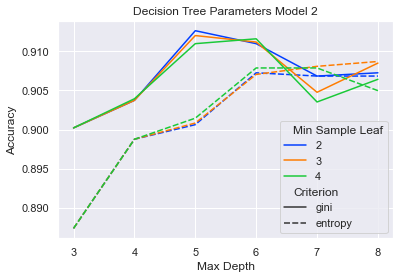

In [20]:
sb.set(rc={"figure.figsize":(10, 8)})
Grid_plot = sb.lineplot(data=results_df, x='Max Depth', y='Accuracy',
                           hue='Min Sample Leaf', style = 'Criterion', palette = 'bright')
Grid_plot.set(title = 'Decision Tree Parameters Model 2')
Grid_plot.get_figure().savefig('../plots/GridSearch_Decision_Tree_model_2.png', dpi=300, bbox_inches='tight')


Best model is:

$Max Depth = 5$

$Min Sample Leaf = 2$

$Criterion = Gini$

In [21]:
model =  DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf = 2, random_state=2023)

In [22]:
pipe = Pipeline(steps=[('data',data_pipe), ('model', model)])

In [23]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('data',
                 Pipeline(steps=[('preprocess',
                                  ColumnTransformer(transformers=[('category',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore'),
                                                                   [('Info',
                                                                     'MatchID',
                                                                     'League'),
                                                                    ('Info',
                                                                     'MatchID',
                                                                     'Year'),
                                                                    ('Info',
                                                                     'MatchID',
                                                                     'Season'),
                                                                    ('Info',
                                                                     'MatchID',
                                                                     'Type'),
                                                                    ('Info',
                                                                     'BlueTag',
                                                                     'TeamTag'),
                                                                    ('Blue',
                                                                     'Top',
                                                                     'Top'),
                                                                    ('Blue',
                                                                     'Top',
                                                                     'TopChamp'),
                                                                    ('Blue',
                                                                     'Jungle...
                                                                    ('Blue',
                                                                     'Support',
                                                                     'Gold_10'),
                                                                    ('Blue',
                                                                     'Support',
                                                                     'Gold_15'),
                                                                    ('Red',
                                                                     'Top',
                                                                     'Gold_5'),
                                                                    ('Red',
                                                                     'Top',
                                                                     'Gold_10'),
                                                                    ('Red',
                                                                     'Top',
                                                                     'Gold_15'),
                                                                    ('Red',
                                                                     'Jungle',
                                                                     'Gold_5'),
                                                                    ('Red',
                                                                     'Jungle',
                                                                     'Gold_10'), ...])])),
                                 ('filter',
                                  SelectKBest(k=20,
                                              score_func=<function chi2 at 0x000002129ACF21

In [24]:
DT_acc = util.print_accuracies(pipe, X_train, y_train, X_val, y_val)

Train accuracy 0.933	Test accuracy 0.906


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [25]:
skf = StratifiedKFold(n_splits=8, shuffle=True, random_state=20220914)

scores = cross_val_score(pipe, X_train, y_train, cv=skf)
SVM_scores = scores

C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 7, 8, 9, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 30, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [5, 6, 7, 8, 9, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\drago\Ana

([], [])

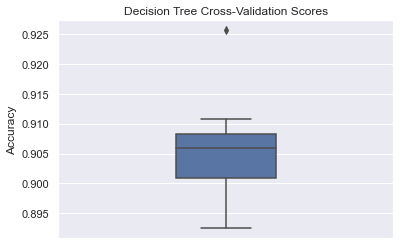

In [26]:
plot = sb.boxplot(data=scores, width=0.3)

plot.set(title = 'Decision Tree Cross-Validation Scores', ylabel='Accuracy')
plt.xticks([], [])

In [27]:
util.print_accuracies(pipe, X_train, y_train, X_val, y_val)

Train accuracy 0.933	Test accuracy 0.906


C:\Users\drago\Anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:188: UserWarning: Found unknown categories in columns [4, 5, 6, 7, 8, 9, 10, 11, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 28, 29, 30, 31, 32, 33, 34, 35] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


[0.9332782482958066, 0.9058629232039637]

## Feature Selection

In [28]:
feature_names = pipe.named_steps['data'].get_feature_names_out()
feature_coefs = pipe.named_steps['model'].feature_importances_
feature_df = pd.DataFrame({'Feature Name': list(feature_names), 'Importance': list(feature_coefs.flatten())})
feature_df.sort_values(by='Importance', axis=0, ascending=False, inplace=True, ignore_index=True)
feature_df.head(20)

,Feature Name,Importance
0,numeric__x97,0.577862
1,numeric__x87,0.311874
2,numeric__x99,0.052367
3,numeric__x91,0.009408
4,numeric__x89,0.008514
5,numeric__x80,0.007614
6,numeric__x95,0.007298
7,numeric__x81,0.006074
8,numeric__x84,0.004113
9,numeric__x82,0.003638


In [29]:
X_cols = pd.DataFrame(X.columns, columns=['column'])
X_cols['column'] = X_cols['column'].astype(str)
X_cols['col'] = np.linspace(0, len(X.columns)-1, num=len(X.columns)).astype(int).astype(str)
X_cols = dict(zip(X_cols.col, X_cols.column))
X_cols

{'0': "('Info', 'MatchID', 'League')",
 '1': "('Info', 'MatchID', 'Year')",
 '2': "('Info', 'MatchID', 'Season')",
 '3': "('Info', 'MatchID', 'Type')",
 '4': "('Info', 'MatchID', 'gamelength')",
 '5': "('Info', 'BlueTag', 'TeamTag')",
 '6': "('Blue', 'Top', 'Top')",
 '7': "('Blue', 'Top', 'TopChamp')",
 '8': "('Blue', 'Jungle', 'Jungle')",
 '9': "('Blue', 'Jungle', 'JungleChamp')",
 '10': "('Blue', 'Middle', 'Middle')",
 '11': "('Blue', 'Middle', 'MiddleChamp')",
 '12': "('Blue', 'ADC', 'ADC')",
 '13': "('Blue', 'ADC', 'ADCChamp')",
 '14': "('Blue', 'Support', 'Support')",
 '15': "('Blue', 'Support', 'SupportChamp')",
 '16': "('Info', 'RedTag', 'TeamTag')",
 '17': "('Red', 'Top', 'Top')",
 '18': "('Red', 'Top', 'TopChamp')",
 '19': "('Red', 'Jungle', 'Jungle')",
 '20': "('Red', 'Jungle', 'JungleChamp')",
 '21': "('Red', 'Middle', 'Middle')",
 '22': "('Red', 'Middle', 'MiddleChamp')",
 '23': "('Red', 'ADC', 'ADC')",
 '24': "('Red', 'ADC', 'ADCChamp')",
 '25': "('Red', 'Support', 'Suppor

In [30]:
list_of_chars=['\(', '\)', '\'']
pattern = '[' +  ''.join(list_of_chars) +  ']'
feature_df['Feature Name 2'] = [ re.sub(', ', '_', re.sub(pattern, '', re.sub('(.*)__x(\d+)',X_cols.get(re.search('x(\d+)', s).group(1)),s))) for s in feature_df['Feature Name']]
feature_df

,Feature Name,Importance,Feature Name 2
0,numeric__x97,0.577862,Red_Support_Assist
1,numeric__x87,0.311874,Blue_Support_Assist
2,numeric__x99,0.052367,Red_Jungle_Assist
3,numeric__x91,0.009408,Red_Middle_Assist
4,numeric__x89,0.008514,Blue_Jungle_Assist
5,numeric__x80,0.007614,Blue_Middle_Kills
6,numeric__x95,0.007298,Red_ADC_Assist
7,numeric__x81,0.006074,Blue_Middle_Assist
8,numeric__x84,0.004113,Blue_ADC_Kills
9,numeric__x82,0.003638,Blue_Top_Kills


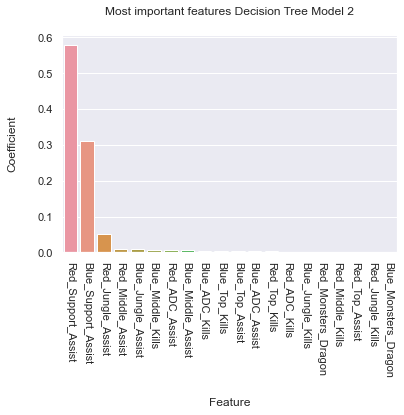

In [31]:
ax = sb.barplot(data=feature_df.iloc[0:20], x='Feature Name 2', y='Importance', orient='v')
ax.tick_params(axis='x', rotation=270)
ax.set_ylabel('Coefficient', rotation=90, labelpad=20)
ax.set_xlabel('Feature', rotation=0, labelpad=20)
ax.set_title('Most important features Decision Tree Model 2', pad=20)
plt.savefig('../plots/Coefs_DT_model_2.png',dpi=300, bbox_inches = "tight")

Saving model

In [32]:
with open("../Models/DT_model_2.pkl", "wb") as f:
    pickle.dump(model, f)